# Credit Risk Analysis using XGBoost

## 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_score
from xgboost import XGBClassifier
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
import warnings
import pickle

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

## 2. Data Loading and Inspection

In [2]:
df = pd.read_csv('german_credit.csv')
df.head()
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Creditability                      1000 non-null   int64
 1   Account Balance                    1000 non-null   int64
 2   Duration of Credit (month)         1000 non-null   int64
 3   Payment Status of Previous Credit  1000 non-null   int64
 4   Purpose                            1000 non-null   int64
 5   Credit Amount                      1000 non-null   int64
 6   Value Savings/Stocks               1000 non-null   int64
 7   Length of current employment       1000 non-null   int64
 8   Instalment per cent                1000 non-null   int64
 9   Sex & Marital Status               1000 non-null   int64
 10  Guarantors                         1000 non-null   int64
 11  Duration in Current address        1000 non-null   int64
 12  Most valuable availab

## 3. Exploratory Data Analysis (EDA)

### Checking for missing values

In [3]:
missing_values = df.isna().sum()
missing_values_percentage = df.isna().sum() / df.shape[0] * 100
missing_values_table = pd.concat([missing_values, missing_values_percentage], axis=1)

### Correlation Matrix

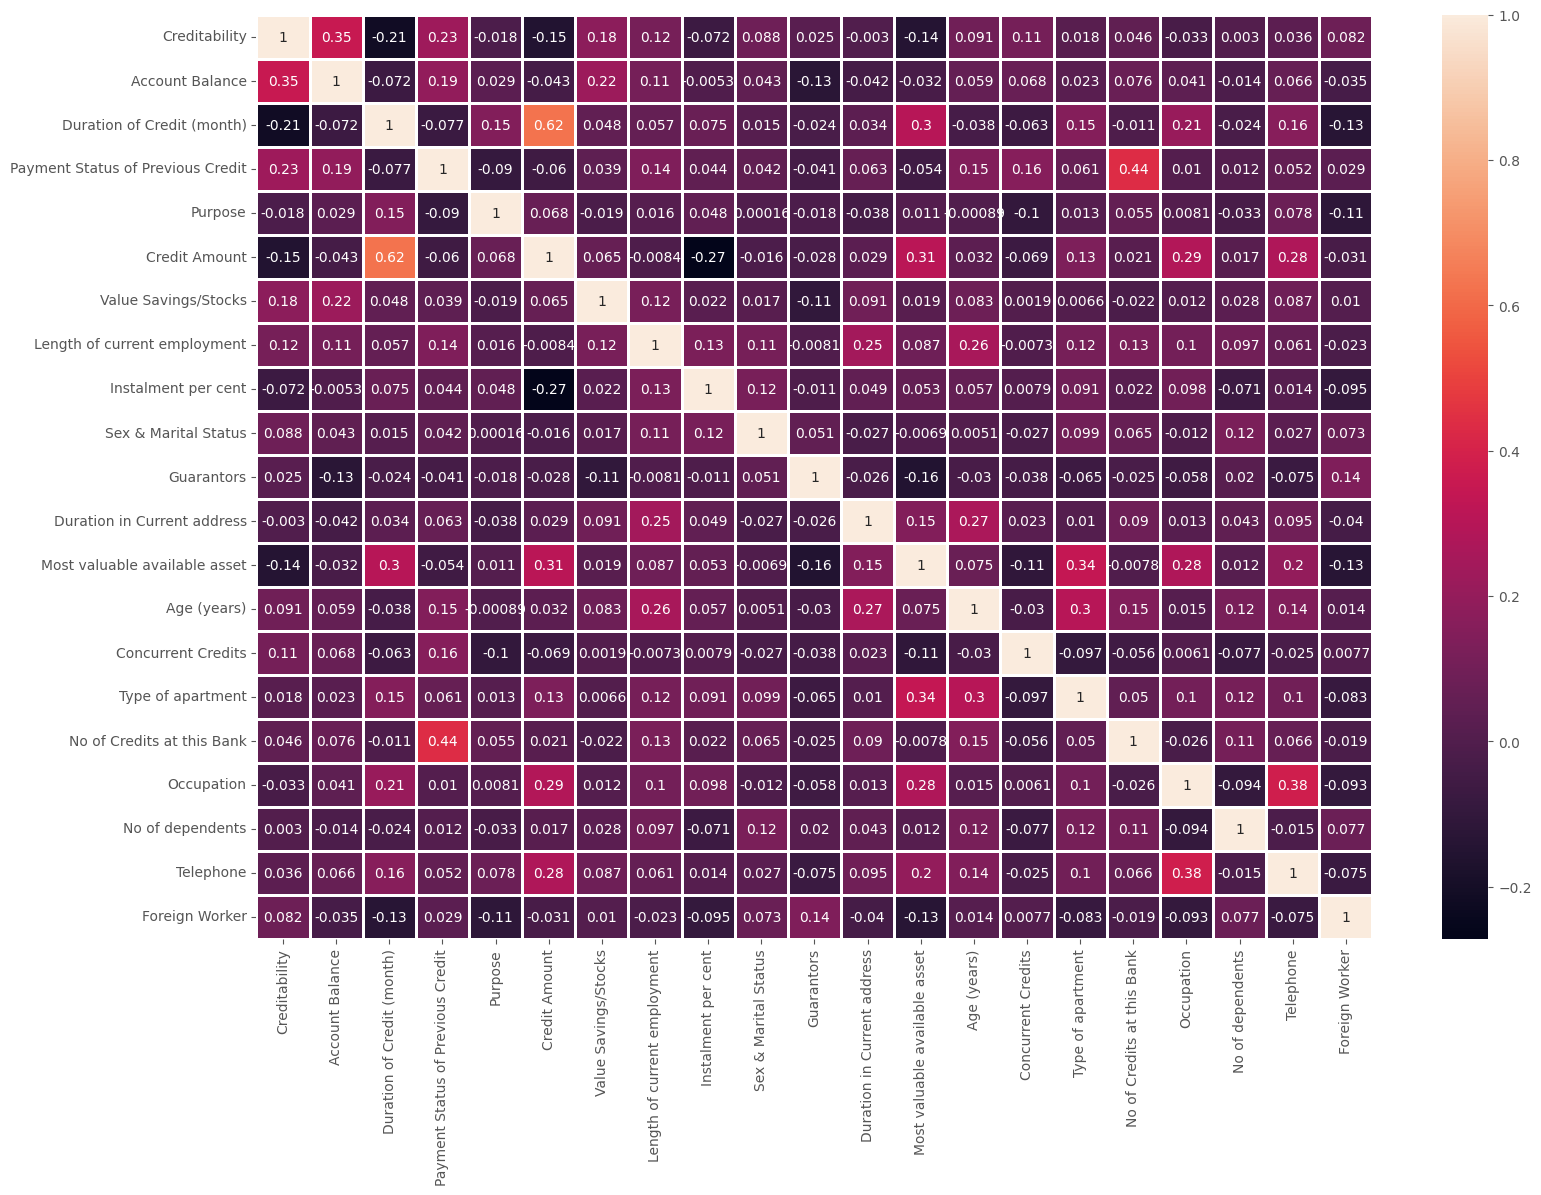

In [4]:
plt.figure(figsize=(18, 12))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt='.2g', linewidths=1)
plt.show()

### Distribution of the target variable

In [5]:
low_credit = df[df["Creditability"] == 0]
high_credit = df[df["Creditability"] == 1]
frac = len(high_credit) / float(len(low_credit))
print(f"High credit fraction: {frac}")

High credit fraction: 2.3333333333333335


### Checking for multicollinearity

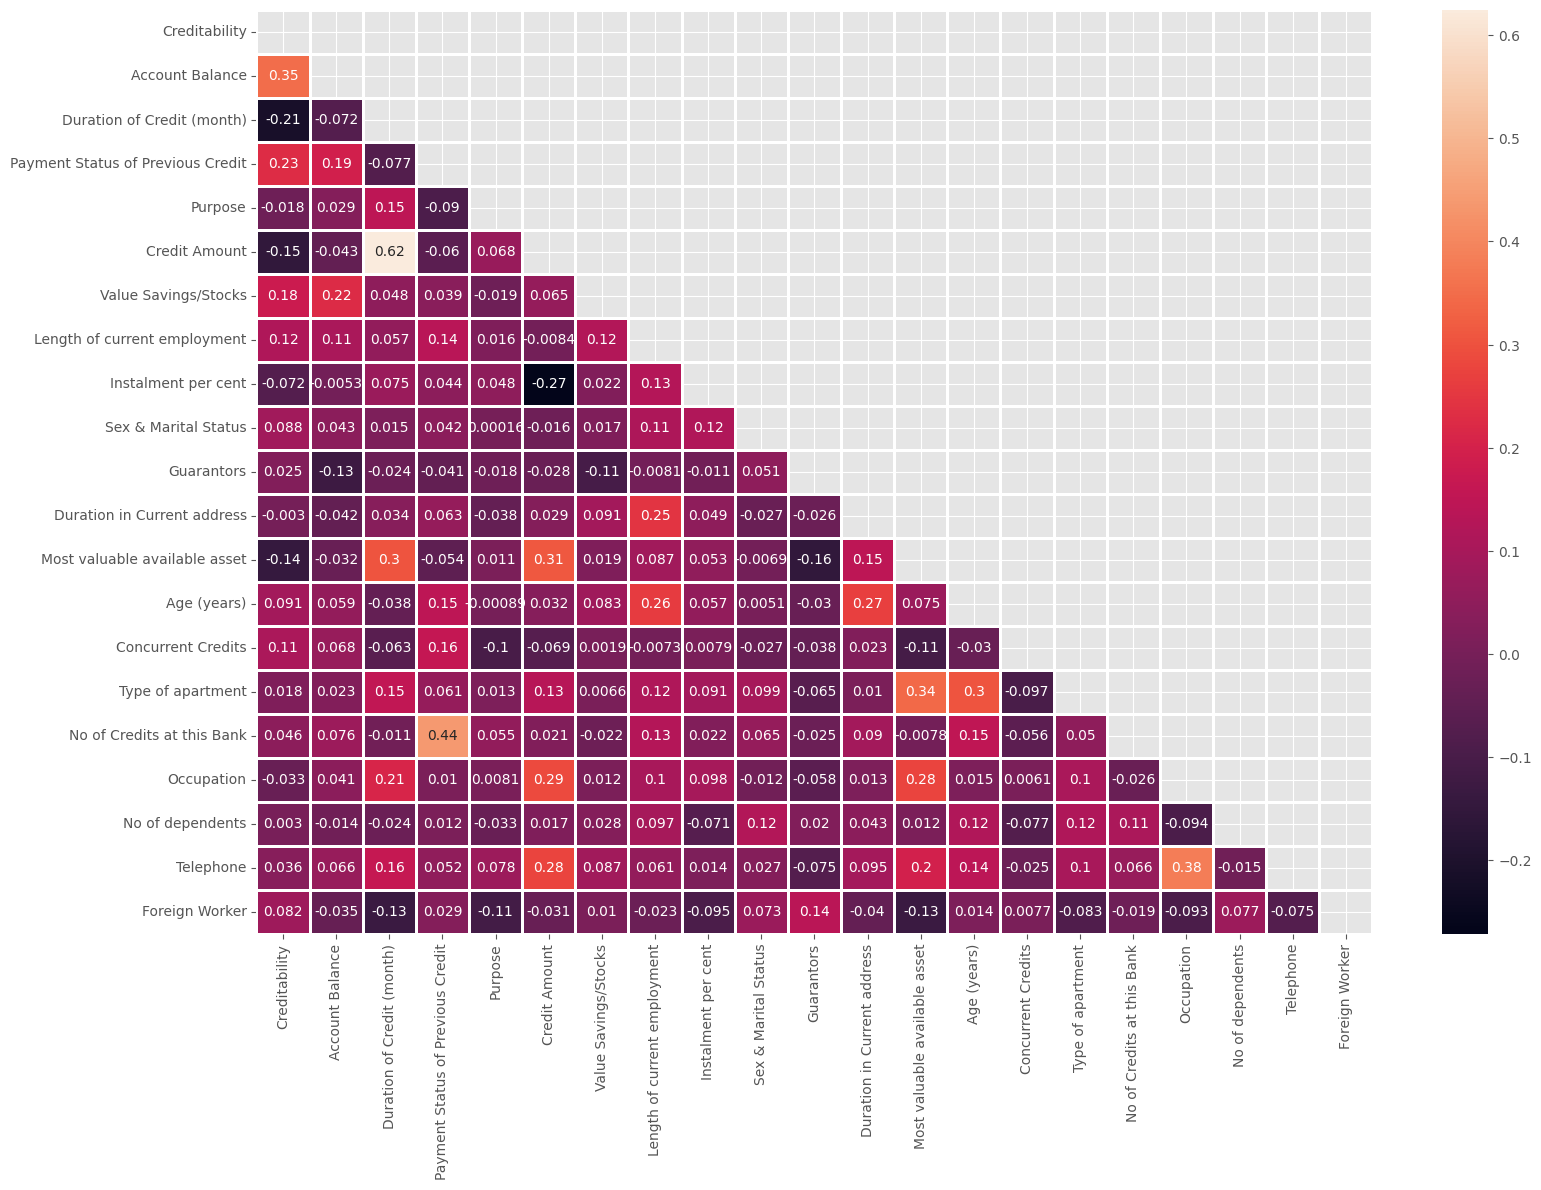

In [6]:
plt.figure(figsize=(18, 12))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2g', linewidths=1)
plt.show()

### Unique values in each column

In [7]:
df.nunique()

Creditability                          2
Account Balance                        4
Duration of Credit (month)            33
Payment Status of Previous Credit      5
Purpose                               10
Credit Amount                        923
Value Savings/Stocks                   5
Length of current employment           5
Instalment per cent                    4
Sex & Marital Status                   4
Guarantors                             3
Duration in Current address            4
Most valuable available asset          4
Age (years)                           53
Concurrent Credits                     3
Type of apartment                      3
No of Credits at this Bank             4
Occupation                             4
No of dependents                       2
Telephone                              2
Foreign Worker                         2
dtype: int64

## 4. Data Preprocessing

### Creating dependent and independent variables

In [8]:
X = df.drop(['Creditability'], axis=1)
y = df['Creditability']

### Visualizing distributions of features

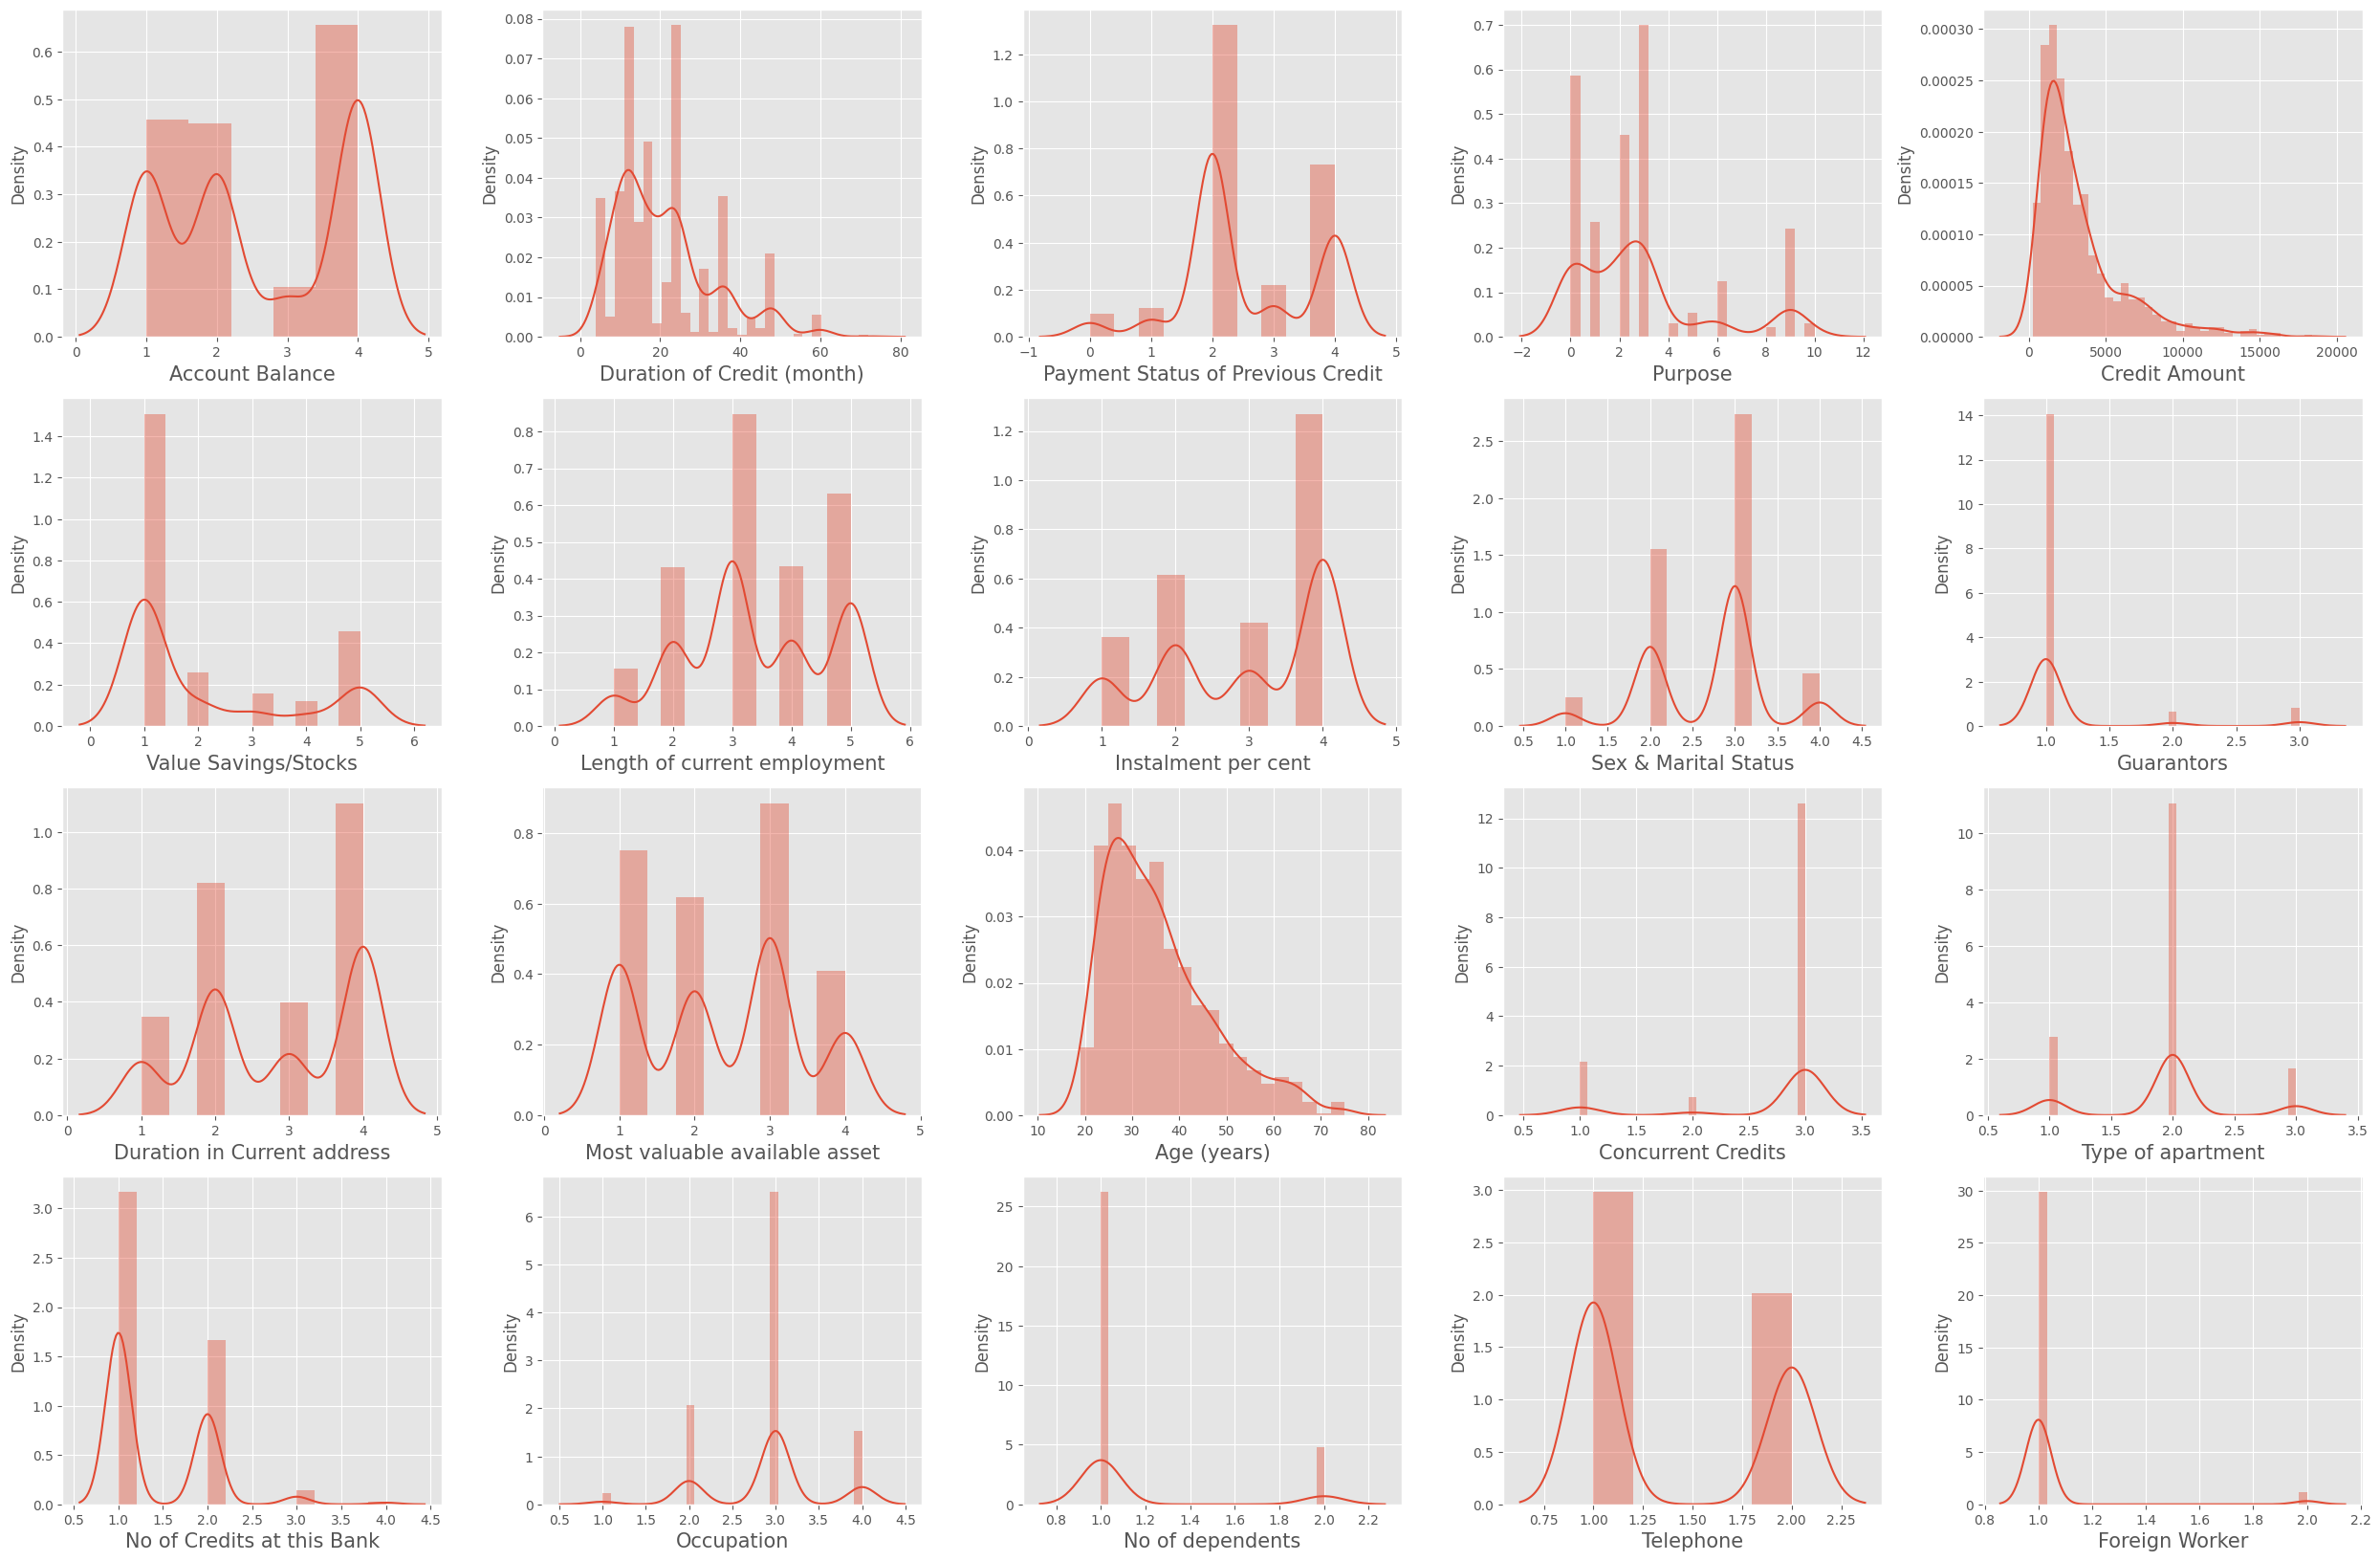

In [9]:
plt.figure(figsize=(25, 20))
plotnumber = 1
for col in X.columns:
    if plotnumber <= 24:
        ax = plt.subplot(5, 5, plotnumber)
        sns.distplot(X[col])
        plt.xlabel(col, fontsize=15)
    plotnumber += 1
plt.tight_layout()
plt.show()

### Handling missing values

In [10]:
# Assuming there's a need to handle missing values based on the EDA
# Fill missing values with median or mode as appropriate
for column in X.columns:
    if X[column].dtype == 'object':
        X[column].fillna(X[column].mode()[0], inplace=True)
    else:
        X[column].fillna(X[column].median(), inplace=True)

### Encoding categorical variables

In [11]:
for column in X.columns:
    if X[column].dtype == 'object':
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column])

### Train-test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

## 5. Model Building and Training using XGBoost

### Initialize XGBoost Classifier

In [13]:
xgbc = XGBClassifier(n_estimators=120)
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=120, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Predictions

In [14]:
y_pred_xgbc = xgbc.predict(X_test)

### Initial Evaluation

In [15]:
precision_xgbc = precision_score(y_test, y_pred_xgbc)
print(f"Precision: {precision_xgbc}")

Precision: 0.7950138504155124


In [16]:
accuracy = accuracy_score(y_test, y_pred_xgbc)
print("Accuracy:", accuracy)

Accuracy: 0.726


### Hyperparameter tuning with RandomizedSearchCV

In [17]:
param_dist = {
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(1, 10),
    'n_estimators': randint(10, 500),
    'gamma': uniform(0.01, 0.1),
    'subsample': uniform(0.1, 0.5),
    'colsample_bytree': uniform(0.1, 0.5)
}

xgbc_rscv = RandomizedSearchCV(
    estimator=xgbc,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

xgbc_rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x157b6e430>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x157b6d190>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1541fc700>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x157b6e580>},
                   scoring='accuracy')

### Best parameters and best score

In [18]:
print('Best hyperparameters: ', xgbc_rscv.best_params_)
print('Best score: ', xgbc_rscv.best_score_)

Best hyperparameters:  {'colsample_bytree': 0.3280901748971453, 'gamma': 0.09911713516572768, 'learning_rate': 0.03255167700355705, 'max_depth': 2, 'n_estimators': 438, 'subsample': 0.4844319125644255}
Best score:  0.778


### Retraining with best parameters

In [19]:
best_params = xgbc_rscv.best_params_
xgb_classifier = XGBClassifier(**best_params)
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)

## 6. Model Evaluation

### Accuracy Score

In [20]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.74


### Confusion Matrix

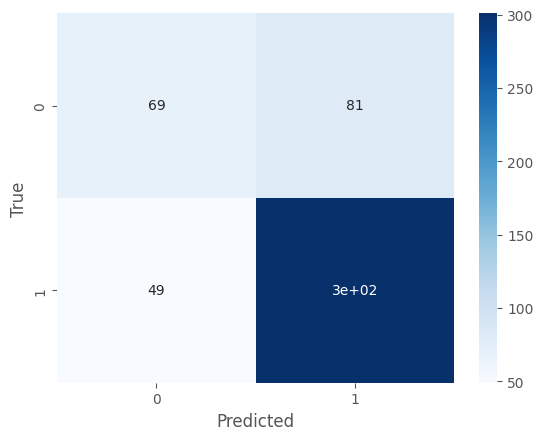

In [21]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Classification Report

In [22]:
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.46      0.51       150
           1       0.79      0.86      0.82       350

    accuracy                           0.74       500
   macro avg       0.69      0.66      0.67       500
weighted avg       0.73      0.74      0.73       500



### ROC AUC Score

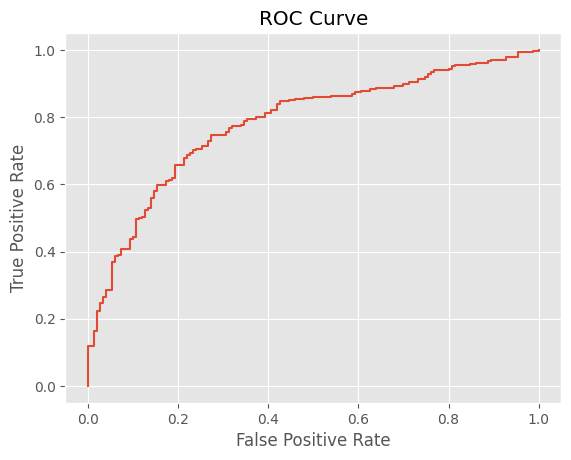

AUC: 0.780895238095238


In [23]:
y_proba = xgb_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

auc = roc_auc_score(y_test, y_proba)
print('AUC:', auc)

### Precision

In [24]:
precision = precision_score(y_test, y_pred)
print('Precision:', precision)

Precision: 0.7879581151832461


## 7. Save Model

In [25]:
pickle.dump(xgbc_rscv, open('xgboost_model.pkl', 'wb'))

## Load Model

In [26]:
# with open('xgboost_model.pkl', 'rb') as f:
#     xgbc_rscv_model = pickle.load(f)
# new_data = pd.DataFrame([[1, 1, 0, 0, 0, 360, 1, 0, 4.5, 8.2]], columns=['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'log_LoanAmount', 'log_TotalIncome'])
# predictions = xgbc_rscv_model.predict(new_data)
# print(predictions)